<a href="https://colab.research.google.com/github/EnoiuDiana/Stroke-Predictor/blob/bori_dev/Stroke_Predictor_ML_Only.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stroke Prediction based on medical and demographical data

## Problem Statement

This project is aimed to help to **decide whether a person is likely to get a stroke**, based on demographical and medical data.

Thus, we framed the problem as a **classification problem**: we intend to tell only whether someone is likely or not to get a stroke, we do not try to precisely predict the likelihood of a stroke.



### Background: what is a Stroke?

([source 1: NHS](https://www.nhs.uk/conditions/stroke/#:~:text=A%20stroke%20is%20a%20serious,damage%20is%20likely%20to%20happen.))

([source 2: CDC](https://www.cdc.gov/stroke/index.htm#:~:text=Stroke%20is%20a%20leading%20cause,of%20serious%20disability%20for%20adults.&text=About%20795%2C000%20people%20in%20the%20United%20States%20have%20a%20stroke%20each%20year.&text=Get%20more%20quick%20facts%20about,Stroke%20is%20preventable.))

A stroke is the event in which the flow of blood to a part of the brain is cut off, thus causing the brain cells to get demaged or die. The effects may include a permanent brain demage, long-term disabilities or even death. 

The direct cause of a stroke is generally a blood clot / a piece of fatty material, blocking an artery (Ischaemic stroke), or the walls of a blood vessel in the brain becoming weak and burst (Haemorrhagic stroke).

It is one of the leading death causes and requires urgent treatment. It is reported to cause almost 800 000 deaths each year in the USA.

### Why our analysis is relevant?

The good thing about strokes is that they're somewhat **preventable** with a healthy lifestyle and also **treatable**, if the patient gets the treatment in time.

**Our analysis will focus on the prevention: we try to understand what life-style choises help to reduce one's exposure to stroke.**

## Data Fetching



*   [source](https://https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset)

**The structure of the dataset**

*   each entry represents one person
*   **label**, to be predicted: boolean variable 'stroke', that tells whether a person is likely to have a stroke
*   **features**, to rely on for the prediction:
  * demographical 
      * *gender* : male, female or other
      * *age*
      * *marital status (ever_married)* : was the person ever married?
      * *work type (work_type)* : children, government job ('Govt_job'), never worked ('never_worked'), private, self-employed
      * *residence (residence_type)* : urban or rural
      * *smoking status* : 'never smoked', 'formerly smoked', 'smokes', 'unknown'
   * medical data
      * *hypertension*: 0, if the patient doesn't have hypertension, 1 otherwise
      * *heart disease (heart_disease)* : 0 if the patient doesn't have any heart disease, 1 otherwise
      * *average blood glucose level (avg_glucose_level)*
      * *body mass index (bmi)*



As expected, the dataset contains the labels as well. Stroke prediction based on demographic and medical data seems much better suited for **supervised learning** indeed, because we would not expect to find a clear separation between people with and without a stroke that could be easily found by a clustering algorithm.

On the other hand, it seems promising to analyse time series representing purely medical data about the patients, such as the blood pressure, cholesterol level, ecg, ..., and try to detect anomalies relying on unsupervised learning algorithms in these time series to predict a stroke.

Note that these two approaches are both feasible but could be used for entirely different purposes:


*   our supervised-learning approach based on medical and demographical data helps to find what lifestyle helps to prevent a stroke
*   a time-series based unsupervised anomaly detection might help to detect the early signs of a stroke and ensure that the patient gets the necessary treatment as soon as possible, thus minimizing the effects of a stroke



## Setup

In [61]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import FunctionTransformer
from sklearn_pandas import DataFrameMapper
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import *
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import sys
assert sys.version_info >= (3, 5)
import warnings
import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import random as python_random
from tensorflow.keras import regularizers

In [13]:
import sys
assert sys.version_info >= (3, 5)
import sklearn
assert sklearn.__version__ >= "0.20"
import tensorflow as tf
assert tf.__version__ >= "2.0"
import os
from tensorflow import keras

In [14]:
def_plot_length = 7
def_fig_size = (def_plot_length, def_plot_length)
def_title_size = 20
random_state = 42
np.random.seed(random_state)
tf.random.set_seed(random_state)

In [15]:
def reset_seeds():
   np.random.seed(random_state) 
   python_random.seed(random_state)
   tf.random.set_seed(random_state)

### Data Gathering

In [16]:
file_path = "https://drive.google.com/file/d/1x3Vu2Egi5LIvd0jkHnZKeBx-Ye0l8sTr/view?usp=sharing"
file_path ='https://drive.google.com/uc?id=' + file_path.split('/')[-2]
stroke_df = pd.read_csv(file_path)

In [17]:
stroke_df = stroke_df.rename(str.lower, axis='columns')
stroke_df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


### Train-Test Split

We split the dataset such that the ratio of those with a stroke is preseved in both parts.

*   **stroke_df**: dataframe used for training and validation
*   **stroke_test_df**: dataframe used for testing. Not used in the decision processer related to model training



In [18]:
X = stroke_df.drop(columns=['stroke'])
y = stroke_df.stroke

In [19]:
X_stroke_tv_df, X_stroke_test_df, y_stroke_tv_df, y_stroke_test_df = train_test_split(X, y, test_size=0.2, random_state=random_state, stratify=y)

In [20]:
X_stroke_tv_df.shape

(4088, 11)

In [21]:
X_stroke_test_df.shape

(1022, 11)

In [22]:
stroke_df = pd.concat([X_stroke_tv_df, y_stroke_tv_df], axis = 1)
stroke_df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
845,25283,Female,48.0,0,0,Yes,Private,Urban,69.21,33.1,never smoked,0
3744,43734,Male,15.0,0,0,No,Private,Rural,122.25,21.0,never smoked,0
4183,47113,Female,67.0,0,0,Yes,Self-employed,Rural,110.42,24.9,never smoked,0
3409,56996,Male,44.0,0,0,Yes,Private,Urban,65.41,24.8,smokes,0
284,26325,Male,14.0,0,0,No,Govt_job,Urban,82.34,31.6,Unknown,0


In [23]:
stroke_test_df = pd.concat([X_stroke_test_df, y_stroke_test_df], axis = 1)

In [24]:
print("Stroke ratio in train-test dataframe: ", stroke_df[stroke_df.stroke == 1].shape[0] / stroke_df.shape[0])

Stroke ratio in train-test dataframe:  0.04867906066536203


In [25]:
print("Stroke ratio in train-test dataframe: ", stroke_test_df[stroke_test_df.stroke == 1].shape[0] / stroke_test_df.shape[0])

Stroke ratio in train-test dataframe:  0.04892367906066536


--> the train+validation and the test datasets are well balanced regarding the ratio of people who had stroke

## Data Preprocessing

### Building a Preprocessing Pipeline

The pipeline performs cleaning based on the approaches found above, and, additionaly, encodes the categorical variables.

#### Dropping outliers

In [26]:
class OutlierDropper(BaseEstimator, TransformerMixin):
    def __init__(self):
        super().__init__()

    def fit(self, df, y=None):
        return self

    def transform(self, df, y=None):
        self.__drop_unknown_genders(df)
        self.__drop_bmi_outliers(df)

        return df
    
    def __drop_unknown_genders(self, df):
        df.drop(df[df['gender'] == 'Other'].index, inplace=True)

    def __drop_bmi_outliers(self, df):
        df.drop(df[df['bmi'] > 60].index, inplace=True)

#### Dropping irrelevant columns

In [27]:
class ColumnDropperTransformer():
    def __init__(self,columns):
        self.columns=columns

    def fit(self, X, y=None):
        return self 

    def transform(self,X,y=None):
        return X.drop(self.columns,axis=1)

#### Categorical variables

In [28]:
bin_categorical_cols = ['ever_married', 'residence_type', 'gender']
larger_categorical_cols = [cname for cname in stroke_df.columns if stroke_df[cname].dtype == "object" and cname not in bin_categorical_cols]
larger_categorical_cols

['work_type', 'smoking_status']

Based on the values of these variables, we can see that 'gender', 'ever_married' and 'residence_type' have just two possible values, so it's safe to assume an ordering between them, and assign 1 to one of the values and 0 to the other. This can be easily done using an OrdinalEncoder.

The other variables, 'work_type' and 'smoking_status' have multiple possible values with no ordering between them so we should apply a OneHotEncoder instead.

In [29]:
cat_var_transformers = [
    ('multi_cat', OneHotEncoder(), larger_categorical_cols),
    ('bin_cat', OrdinalEncoder(), bin_categorical_cols),
]

#### Numerical Variables

We only expect to have missing values in the BMI feature. As discussed above, a SimpleImputer with a median strategy is the most promising for BMI values, and for simplicity, we'll apply the same imputer for the other numerical columns as well.

In [30]:
# Select numerical columns
numerical_cols = [cname for cname in stroke_df.columns if stroke_df[cname].dtype in ['int64', 'float64']]
numerical_cols.remove('stroke')
numerical_cols.remove('id')
numerical_cols

['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi']

In [31]:
num_var_transformers = [
    ('num_var', SimpleImputer(strategy='median'), numerical_cols)
]

#### ColumnTransformer integrating categoric and numeric variables

In [32]:
column_transformer = ColumnTransformer(
    transformers = cat_var_transformers + num_var_transformers,
    remainder = 'passthrough'
)

#### Resetting Feature Names of dataframe after ColumnTransformer

In [33]:
class ColumnTransformerFeatureNameResetter(BaseEstimator, TransformerMixin):
    def __init__(self, renamer_column_transformer, init_df_columns):
        super().__init__()
        self.__renamer_column_transformer = renamer_column_transformer
        self.__init_df_columns = init_df_columns
        self.__columns = None

    def fit(self, df, y=None):
        return self

    def transform(self, df, y=None):

        df = pd.DataFrame(df)

        df.columns = self.__get_columns_from_transformer(self.__renamer_column_transformer, self.__init_df_columns)

        self.__columns = df.columns

        df[df.columns] = df[df.columns].apply(pd.to_numeric, errors='coerce')

        return df

    def get_columns(self):
        return self.__columns

    def __get_columns_from_transformer(self, column_transformer, input_colums):    
        """
        source: https://github.com/scikit-learn/scikit-learn/issues/12525#issuecomment-744424900
        """
        col_name = []

        for transformer_in_columns in column_transformer.transformers_[:-1]: #the last transformer is ColumnTransformer's 'remainder'
            raw_col_name = transformer_in_columns[2]
            if isinstance(transformer_in_columns[1],Pipeline): 
                transformer = transformer_in_columns[1].steps[-1][1]
            else:
                transformer = transformer_in_columns[1]
            try:
                names = transformer.get_feature_names_out(raw_col_name)
            except AttributeError: # if no 'get_feature_names' function, use raw column name
                names = raw_col_name
            if isinstance(names,np.ndarray): # eg.
                col_name += names.tolist()
            elif isinstance(names,list):
                col_name += names    
            elif isinstance(names,str):
                col_name.append(names)

        [_, _, reminder_columns] = column_transformer.transformers_[-1]

        for col_idx in reminder_columns:
            col_name.append(input_colums[col_idx])

        return col_name

#### Custom Transformers

In [34]:
class WorkTypeTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        super().__init__()

    def fit(self, df, y=None):
        return self

    def transform(self, df, y=None):
        df['work_type'] = df.apply(
            lambda row: "children" if ((row['work_type'] == 'Never_worked') & (row['age'] < 18)) else row['work_type'],
            axis=1
        )

        return df

In [35]:
class SmokingStatusTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        super().__init__()

    def fit(self, df, y=None):
        return self

    def transform(self, df, y=None):
        df.smoking_status = np.where(np.logical_and(df.age < 10, df.smoking_status == 'Unknown'), "never smoked", df.smoking_status)

        return df

#### Scaling Values

It is known that most ML algorithms perform better if the features have similar scales, as it is the case in out dataframe: for example, BMI values have the range [0, 60], whereas avg_glucose_level values are in the interval [50, 270]. 

To overcome this issue, we should scale all the values. Since many of our variables do not follow a normal distribution but are rather skewed (see BMI - right skewed, or avg_glucose_level - doubles peaked), and we have many binary-values nominal variables as well marked with 0 or 1, we should use the MinMaxScaler instead of the StandardScaler.

In [36]:
scaler = MinMaxScaler()

In [37]:
class ScalerFeatureNameResetter(BaseEstimator, TransformerMixin):
    def __init__(self, renamer_scaler, init_cols):
        super().__init__()
        self.__renamer_scaler = renamer_scaler
        self.__init_cols = init_cols

    def fit(self, df, y=None):
        return self

    def transform(self, df, y=None):

        df = pd.DataFrame(df)

        df.columns = self.__renamer_scaler.get_feature_names_out(self.__init_cols)
        return df

#### Integrating all steps in a pipeline

In [38]:
processed_columns = stroke_df.drop(['id'], axis=1).columns
column_transformer_name_resetter = ColumnTransformerFeatureNameResetter(column_transformer, processed_columns)
processed_columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

In [39]:
preprocesser_pipeline = Pipeline([
        ('drop_irrelevant_features', ColumnDropperTransformer("id")),
        ('drop_outliers', OutlierDropper()), 
        ('work_type_replacement_for_children', WorkTypeTransformer()), 
        ('smoking_status_replacement_for_small_children', SmokingStatusTransformer()), 
        ('column_processing', column_transformer),
        ('reset_feature_names', column_transformer_name_resetter),
        ('scaling', scaler),
        ('reset_scaled_feature_names', ScalerFeatureNameResetter(scaler, column_transformer_name_resetter.get_columns()))
])

In [40]:
stroke_df = pd.DataFrame(preprocesser_pipeline.fit_transform(stroke_df))
stroke_df

,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,ever_married,residence_type,gender,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.584961,0.0,0.0,0.065045,0.461538,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.182129,0.0,0.0,0.309898,0.216599,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.816895,0.0,0.0,0.255286,0.295547,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.536133,0.0,0.0,0.047503,0.293522,0.0
4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.169922,0.0,0.0,0.125658,0.431174,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4069,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.548340,0.0,0.0,0.174222,0.502024,0.0
4070,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.194336,0.0,0.0,0.269366,0.186235,0.0
4071,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.743652,0.0,0.0,0.108623,0.524291,0.0
4072,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.377441,0.0,0.0,0.087388,0.317814,0.0


In [41]:
test_stroke_df = pd.DataFrame(preprocesser_pipeline.fit_transform(stroke_test_df))
test_stroke_df

,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,ever_married,residence_type,gender,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.768066,0.0,0.0,0.108170,0.491266,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.523926,0.0,0.0,0.147916,0.458515,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.279785,0.0,0.0,0.336284,0.358079,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.255371,0.0,0.0,0.720085,0.275109,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.816895,0.0,0.0,0.273511,0.305677,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.000000,0.0,0.0,0.126913,0.299127,0.0
1018,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.414062,0.0,0.0,0.305157,0.451965,0.0
1019,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.609375,0.0,0.0,0.173723,0.185590,0.0
1020,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.182129,0.0,0.0,0.034424,0.436681,0.0


## Building a Predictive Model

### Splitting the Features and the Label

In [42]:
X_train = stroke_df.drop(columns=['stroke'])
y_train = stroke_df.stroke
X_test = test_stroke_df.drop(columns=['stroke'])
y_test = test_stroke_df.stroke

In [43]:
X = pd.concat([X_train, X_test], axis = 0)

In [44]:
y = pd.concat([y_train, y_test], axis = 0)

In [45]:
X_train.shape

(4074, 17)

In [46]:
y_train.shape

(4074,)

### Train-Validation Split

Since our dataset is quite small, we should prefer performing a cross validation whenever possible. However, when training a model is computationally expensive, we may use the below train-validation split to evaluate our model.

In [47]:
X_train1, X_valid1, y_train1, y_valid1 = train_test_split(X_train, y_train, test_size=0.2, random_state=random_state, stratify=y_train)

### Handling imbalanced data

As we have shown above, only slightly less than 5% of our samples represent people who had a stroke. Such a strong imbalance in the dataset makes it hard for most machine learning algorithms to learn the particularities of the minority class and detect a decision bondary between the classes: it's likely that most models will tend to predict most entries to have a stroke, because this would allow them to gain a ~95% accuracy without any further knowledge.

However, as our goal is exactly that of understanding what contributes to one's increased tendency to get a stroke, we should make sure somehow that the entries with a stroke have a high enough weight in the ML model. 

Collecting more data is not a solution, no only, becaus ewe do not have the time and resources for that, but also because the imbalance is representative for the population: we can never expect that 50% of a randomly sampled population, from any country, has had a stroke (fortunately).

We'll consider multiple approacehs for overcoming this issue:

1. **applying different class weights**
3. **adding synthetic samples to the minority class (stroke=1) + undersampling the majority class**

#### Using class weights

One wasy to overcome the imbalance issue is applying different weights to the classes when training the model: the errors occuring because of mispredicting entries belonging to the minority class will be added to the overall loss with a higher multiplicative factor. Thus, the model will strive more for an accurate prediction of the minority classes as well.

#### SMOTE


One of the possible solutions is simply balancing the dataset by adding sytnhetic entries to the minority class. We'll apply the SMOTE method ("Synthetic Minority Oversampling Technique"), which is based on synthesising new data entries along the lines connecting close real entries of the minority class (in an n-dimensional space, if there are n features).

However, since we would need to synthetically create 94% of the final entries in the minority class, this huge amount of artificial data may cause the model to learn the particularities introduced by the SMOTE method instead of the general characteristics of the class. 

As a compromise, we'll first undersample the majority class (see [this article for an explanation](https://arxiv.org/abs/1106.1813) of why undersampling + SMOTE performs better than plain undersampling), and apply SMOTE for balancing the dataset only afterwards. This way, the amount of artificial entries is somewhat reduced.

In [48]:
pip install imbalanced-learn

In [49]:
y_train1[y_train1==1].shape[0]

159

In [50]:
y_train1[y_train1==0].shape[0]

3100

In [51]:
undersampler = RandomUnderSampler(sampling_strategy={
        0: int(y_train1[y_train1==0].shape[0] / 4),
        1: y_train1[y_train1==1].shape[0]
    }, random_state=random_state)
us_X_train1, us_y_train1 = undersampler.fit_resample(X_train1, y_train1)

In [52]:
oversample = SMOTE()
smote_X_train1, smote_y_train1 = oversample.fit_resample(us_X_train1, us_y_train1)

### Expectations from the Model

Since the model that we build acts as a binary classifier, it it only natural that we rely on the confusion matrix to evaluate our model. 

However, we should decide which confusion-matrix-related metrics is most important for us: **do we care more about precision, i.e. making sure that all people said to have had a stroke by the model indeed had a stroke, or recall, i.e. maximizing the probability that a person who had a stroke is detected by the model as such?** Or maybe should we take both into account, in form of a more complex metrics? It is likely that at some point we'll need to make a compromise, due to the precision-recall tradeoff concept.

In the context of medical analysis, the first intuition may be that the recall should have a higher weight in deciding which model fits best. In general, when it comes to detecting such mortal diseases, **the cost of not detecting someone's tendency to get the disease is likely death**. We generally consider the death of a human being to be a far higher cost compared to the financial costs related to unnecessary medical analysis and preventive treatment. 

There's one mistake in the above train of thought though: note that the goal of our analysis is not that of deciding whether someone needs treatment, surgery, medicines or any other measue to avoid a stroke when they are already close to getting it, rather that of getting an insight into lifestyle choices that may influence one's tendency to get a stroke. In this context, we want to give the readers a picture as accurate as possible. 


*   *if we focused on precision only*, probably some factors leading to a stroke may be underestimated, causing the readers taking lifestyle choices based on our analysis to be overconfident in the healthiness of their lifestyle
*   *if we considered recall only*, the opposite may happen, some factors leading to stroke are likely to be overestimated, causing the people to take otherwise painful decisions in order to avoid a stroke (such as changing a job, restricting themselves a healthier, but less enjoyable diet, ...)

**Thus, we should use a metric that combines recall and precision. Such a metric is the F1-score, the harmonic mean of recall and precision.**

Additionally, it may help us to compare models or to find the best hyperparameters for each model to take a look at the **Precision/Recall-curve**. 

We may take into account the ROC curve as well, but it was shown that it is not a good indicator in case the input dataset is highly unbalanced. As we only have 5% of the entries with a positive 'stroke' label, we should stick to the Precision/Recall-curve instead.

### Helper functions

In [53]:
def plot_confusion_matrix_with_percentages(cf_matrix, title='Confusion Matrix'):
  ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

  ax.set_title(title, fontsize=def_title_size);
  ax.set_xlabel('\nPredicted Values')
  ax.set_ylabel('Actual Values ');

  ## Ticket labels - List must be in alphabetical order
  ax.xaxis.set_ticklabels(['False','True'])
  ax.yaxis.set_ticklabels(['False','True'])

  ## Display the visualization of the Confusion Matrix.
  plt.show()

In [54]:
def print_metrics(y_true, y_pred):
  print("Precision: ", precision_score(y_true, y_pred))
  print("Recall: ", recall_score(y_true, y_pred))
  print("F1 score: ", f1_score(y_true, y_pred))

In [96]:
def plot_precision_recall_curve(y_true, y_pred_score):
  #calculate precision and recall
  precision, recall, thresholds = precision_recall_curve(y_true, y_pred_score)

  #create precision recall curve
  fig, ax = plt.subplots()
  ax.plot(recall, precision, color='purple')

  #add axis labels to plot
  ax.set_title('Precision-Recall Curve', fontsize=def_title_size)
  ax.set_ylabel('Precision')
  ax.set_xlabel('Recall')

  #display plot
  plt.show()

In [56]:
def call_cross_val_predict(model, X_train, y_train, title):
  y_pred = cross_val_predict(model, X_train, y_train, cv=5)
  conf_mat = confusion_matrix(y_train, y_pred)
  plot_confusion_matrix_with_percentages(conf_mat, title)
  print_metrics(y_train, y_pred)

In [66]:
def plot_confusion_matrix(y_valid, y_pred, title):
  conf_mat = confusion_matrix(y_valid, y_pred)
  plot_confusion_matrix_with_percentages(conf_mat, title)
  print_metrics(y_valid, y_pred)

In [58]:
def get_weight_pairs_spec(start, stop, step):
  class1_weights = np.arange(start, stop, step)
  class2_weights = 100 - class1_weights
  weight_pairs = list(zip(class1_weights, class2_weights))
  weight_pairs_spec = []
  for weight0, weight1 in weight_pairs:
    weight_pairs_spec.append({0: weight0, 1: weight1})
  return weight_pairs_spec

In [59]:
def get_cross_val_detailed_results_df(grid_model):
  results = pd.DataFrame(grid_model.cv_results_)
  results['f1_train_test_difference'] = results['mean_train_f1'] - results['mean_test_f1']
  return results[['mean_test_f1', 'mean_train_f1', 'mean_test_recall', 'mean_train_recall', 'mean_test_precision', 'mean_train_precision', 'params', 'f1_train_test_difference']].round(3)

### Experiments with Logistic Regression Models

#### Simple Logistic Regression

In [85]:
log_reg = LogisticRegression(random_state=random_state)

In [86]:
print("Accuracies obtained with LogisticRegression using 5-fold cross-validation")
scores = cross_val_score(log_reg, X_train, y_train, cv = 5)
print(scores)

Accuracies obtained with LogisticRegression using 5-fold cross-validation
[0.95092025 0.95092025 0.95092025 0.95092025 0.95208845]


In [87]:
mean_score = scores.mean()
print("Mean Accuracy: ", mean_score)

Mean Accuracy:  0.9511538867367089


At first sight, obtaining a 95.1% accuracy seems truly promising. But, if we take a closer look at the data, it's in fact highly disappointing, given that only 4.86% of our labels have a positive value. This means, that even a model which would have predicted stroke=0 for all entries would have reached a very similar accuracy.

We should take a look at the precision and recall metrics to understand better the results produced by this model.

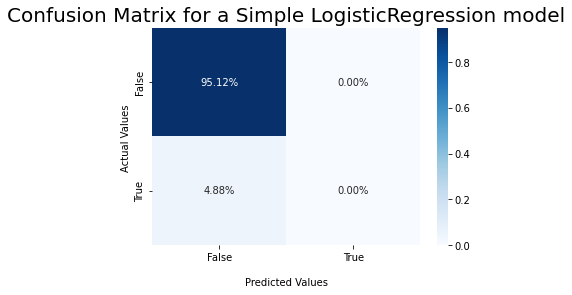

Precision:  0.0
Recall:  0.0
F1 score:  0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [88]:
call_cross_val_predict(log_reg, X_train, y_train, "Confusion Matrix for a Simple LogisticRegression model")

Unfortunately, this confusion matrix confirms what we have been worrying about: **this simple LogisticRegression simply classifies all entries as 'stroke=0'. This is certainly not what we wanted!**

The primary reason for this error is the fact that our dataset is **highly unbalanced.** As a workaround, we may try to artificially assign higher weights to the minority class (stroke=1), that we are trying to predict.

#### Weighted Logistic Regression

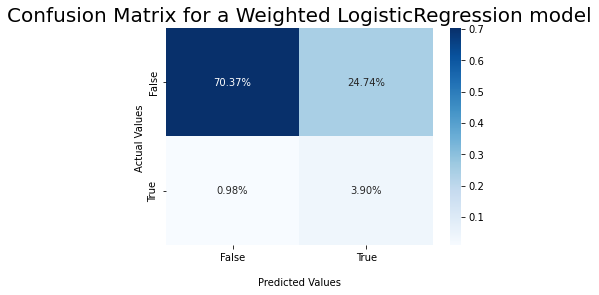

Precision:  0.13624678663239073
Recall:  0.7989949748743719
F1 score:  0.23279648609077597


In [89]:
weighted_log_reg = LogisticRegression(random_state=random_state, class_weight='balanced', max_iter=1000, tol=1e-6)
call_cross_val_predict(weighted_log_reg, X_train, y_train, "Confusion Matrix for a Weighted LogisticRegression model")

The improvement is fascinating: although the precision is still quite low, a recall 0f 0.79 is actually quite promising. This means that the model detects the people who had a stroke quite well, but it additionally predicts lots of other people to have a stroke too. 

This result **suggests that this time the weight of the minority class was in fact too high**. We should ask ourselves the question: can we find a parameter for the class weights that allows us to balance the precision and the recall?

Moreover, there's also a chance that the model **may have overfitted**. To overcome this issue, we should try to apply a stronger regularization. Note that L2 regularization is applied by default in LogisticRegression models, but we can make it stronger by increasing the C 'regularization strength' parameter.

Let's use grid-search to find that out!

##### Grid-Search for finding the appropriate class weights and regularisation strength

In [90]:
weight_pairs_spec = get_weight_pairs_spec(1, 46, 3)
weight_pairs_spec

[{0: 1, 1: 99},
 {0: 4, 1: 96},
 {0: 7, 1: 93},
 {0: 10, 1: 90},
 {0: 13, 1: 87},
 {0: 16, 1: 84},
 {0: 19, 1: 81},
 {0: 22, 1: 78},
 {0: 25, 1: 75},
 {0: 28, 1: 72},
 {0: 31, 1: 69},
 {0: 34, 1: 66},
 {0: 37, 1: 63},
 {0: 40, 1: 60},
 {0: 43, 1: 57}]

In [91]:
weighted_log_reg = LogisticRegression(random_state=random_state, max_iter=1000, tol=1e-6)
reg_strengths = [0.001, 0.1, 1, 10, 1000]
grid_values = {'class_weight': weight_pairs_spec, 'C': reg_strengths}
grid_weighted_log_reg = GridSearchCV(weighted_log_reg, cv = 3, param_grid = grid_values, scoring = ['f1', 'recall', 'precision'], refit='f1', return_train_score=True)
grid_weighted_log_reg.fit(X_train1, y_train1)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined a

GridSearchCV(cv=3,
             estimator=LogisticRegression(max_iter=1000, random_state=42,
                                          tol=1e-06),
             param_grid={'C': [0.001, 0.1, 1, 10, 1000],
                         'class_weight': [{0: 1, 1: 99}, {0: 4, 1: 96},
                                          {0: 7, 1: 93}, {0: 10, 1: 90},
                                          {0: 13, 1: 87}, {0: 16, 1: 84},
                                          {0: 19, 1: 81}, {0: 22, 1: 78},
                                          {0: 25, 1: 75}, {0: 28, 1: 72},
                                          {0: 31, 1: 69}, {0: 34, 1: 66},
                                          {0: 37, 1: 63}, {0: 40, 1: 60},
                                          {0: 43, 1: 57}]},
             refit='f1', return_train_score=True,
             scoring=['f1', 'recall', 'precision'])

In [92]:
print(f'Best f1 score: {grid_weighted_log_reg .best_score_} with param: {grid_weighted_log_reg .best_params_}')

Best f1 score: 0.26524358105564344 with param: {'C': 0.1, 'class_weight': {0: 10, 1: 90}}


In [93]:
get_cross_val_detailed_results_df(grid_weighted_log_reg)

,mean_test_f1,mean_train_f1,mean_test_recall,mean_train_recall,mean_test_precision,mean_train_precision,params,f1_train_test_difference
0,0.093,0.093,1.000,1.000,0.049,0.049,"{'C': 0.001, 'class_weight': {0: 1, 1: 99}}",-0.000
1,0.163,0.166,0.918,0.937,0.090,0.091,"{'C': 0.001, 'class_weight': {0: 4, 1: 96}}",0.003
2,0.239,0.242,0.453,0.459,0.162,0.164,"{'C': 0.001, 'class_weight': {0: 7, 1: 93}}",0.003
3,0.138,0.189,0.138,0.179,0.137,0.201,"{'C': 0.001, 'class_weight': {0: 10, 1: 90}}",0.052
4,0.057,0.097,0.038,0.063,0.128,0.213,"{'C': 0.001, 'class_weight': {0: 13, 1: 87}}",0.040
...,...,...,...,...,...,...,...,...
70,0.128,0.126,0.088,0.082,0.233,0.274,"{'C': 1000, 'class_weight': {0: 31, 1: 69}}",-0.002
71,0.053,0.103,0.031,0.063,0.175,0.305,"{'C': 1000, 'class_weight': {0: 34, 1: 66}}",0.050
72,0.034,0.076,0.019,0.044,0.181,0.269,"{'C': 1000, 'class_weight': {0: 37, 1: 63}}",0.042
73,0.035,0.046,0.019,0.025,0.261,0.267,"{'C': 1000, 'class_weight': {0: 40, 1: 60}}",0.011


It seems like the best class weights that we can use are **10 for the stroke=0 and 90 for the stroke=1 class**, which are different from the balanced class weights.

On the other hand, regularization doesn't seem to make a difference: if we take a look at the difference between the f1 scores on the train and the test sets in crowss validtaion, we see minor differences independently from the strength of the regularization applied. This proved that our model **did not overfit**.

###### Evaluation on the validation set

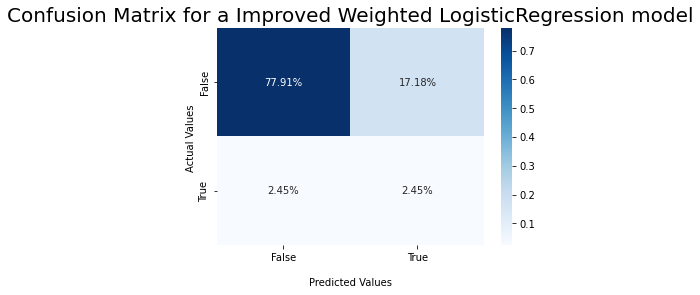

Precision:  0.125
Recall:  0.5
F1 score:  0.2


In [94]:
y_pred = grid_weighted_log_reg.predict(X_valid1)
plot_confusion_matrix(y_valid1, y_pred, title = "Confusion Matrix for a Improved Weighted LogisticRegression model")

Indeed, by setting the weight of the minority class slightly lower, we obtained a better result. However, we still cannot be satisfied with the precision of this model. Let's take a look at the precision-recall curve to see whether we could find a better compromise between the precision and the recall.

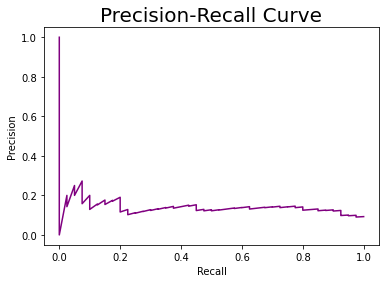

In [97]:
y_score_pred = grid_weighted_log_reg.predict_proba(X_valid1)[:, 1]
plot_precision_recall_curve(y_valid1, y_score_pred)

The curve has a very unsatisfying shape: we would expect it to be close to the upper-right corner, but in reality there's no decision threshold for which both the precision and the recall would be acceptably high. 

#### Logistic Regression on a SMOTE-balanced dataset

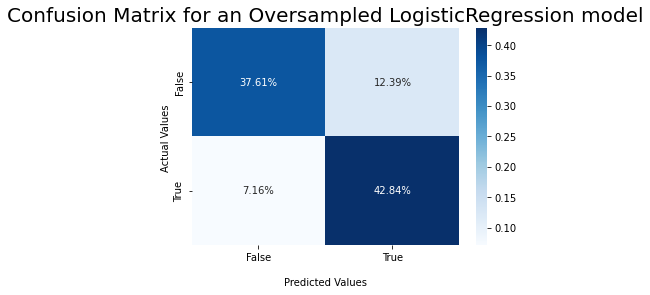

Precision:  0.7757009345794392
Recall:  0.8567741935483871
F1 score:  0.8142244022072348


In [98]:
smote_log_reg = LogisticRegression(random_state=random_state, max_iter=1000, tol=1e-6)
call_cross_val_predict(smote_log_reg, smote_X_train1, smote_y_train1, "Confusion Matrix for an Oversampled LogisticRegression model")

This score looks really good, but is **misleading**: it only shows that the model is good ad predicting the class of the entries in the SMOTE-oversampeld dataset. But, it is possible that the model only learnt the particularities o fthe artificially synthesised data, and is not working well on the original dataset. Note that under- and oversampling is not a data preprocessing step that we should later apply for the production data as well: these steps should only be used in training.

The correct process would be that of:
1. training the model on the balanced dataset
2. evaluating the model on the original validation dataset

Let's see what happens if we evaluate the model on the validation set that we originally separated:

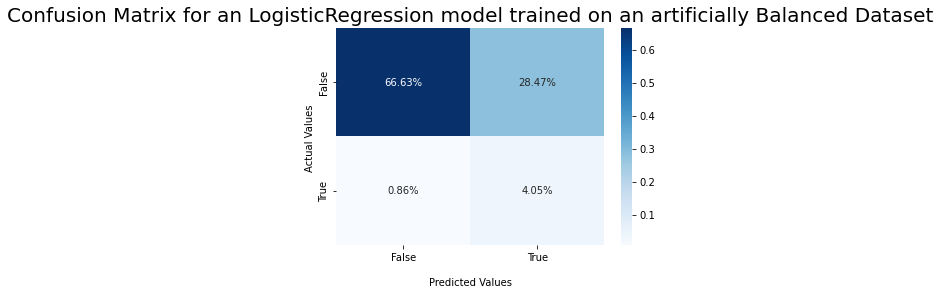

Precision:  0.12452830188679245
Recall:  0.825
F1 score:  0.21639344262295082


In [99]:
smote_log_reg.fit(smote_X_train1, smote_y_train1)
y_pred = smote_log_reg.predict(X_valid1)
plot_confusion_matrix(y_valid1, y_pred, title = "Confusion Matrix for an LogisticRegression model trained on an artificially Balanced Dataset")

We can see that overall the model doesn't seem to perform any better that the one obtained by setting higher class weights, the f1-scores are in fact very similar, despite using completely different methods for overcoming the imbalance issue.

#### Conclusions about the Logistic Regression

To sum op our experiments with Logistic Regression models, we can simply say that none of them provided good enough results. 

**The best f1-score was 0.265** with the hyperparameters:


*   class weights: {0: 10, 1: 90}
*   C: 0.1
*   max_iter: 1000

Before taking the next steps, we should think about why the LogisticRegression performed so badly. To answer this question, we should dive deeper into the working mechanism of the logistic regression models: they estimate the probability of an entry belonging to a certain class by applying the sigmoid function to a weighted linear combination of the features. **The key here is that it cannot actually learn non-linear relationships between the features and the label.** Knowing that we didn't have any feature in our dataset, which would have been highly correlated (thus showing a strong linear relationship with our label) with the label, it is in fact not surprising that a logistic regression cannot perform well. 

So, as a next step, we should focus on ML models capable of treating non-linear relationships.

### Experiments with Support Vector Machines

#### With Class Weights

SVMs generally work better with values centered around the mean, so we'll apply a StandardScaler to achieve that.

Moreover, we should use a higher penalty weight for the minority class to overcome the issue of having a highly unbalanced dataset.

Accuracies obtained with SVC using 5-fold cross-validation
[0.95092025 0.95092025 0.95092025 0.95092025 0.95208845]
Mean Accuracy:  0.9511538867367089


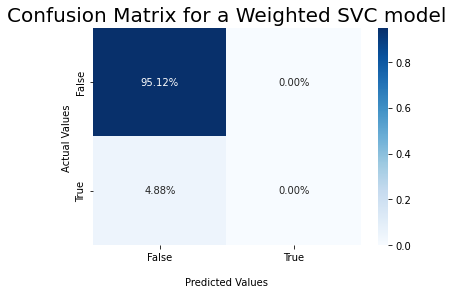

Precision:  0.0
Recall:  0.0
F1 score:  0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [100]:
rbf_kernel_svm_clf = Pipeline([
      ('scaler', StandardScaler()),
      ('svm_clf', SVC(kernel="rbf", gamma=5, C=0.001, class_weight='balanced', random_state=random_state))  
])

print("Accuracies obtained with SVC using 5-fold cross-validation")
scores = cross_val_score(rbf_kernel_svm_clf, X_train, y_train, cv = 5)
print(scores)
mean_score = scores.mean()
print("Mean Accuracy: ", mean_score)

call_cross_val_predict(rbf_kernel_svm_clf, X_train, y_train, "Confusion Matrix for a Weighted SVC model")

We ended up with the same mistake: all entries are classified as having no-stroke, despite explicitly telling the SVC to use higher weights for entries with a stroke.

**A possible cause of the mistake is overfitting and underfitting**: SVCs are really sensitive to the **regularization parameter C and the gamma coefficient**. In general, we can say that 


*   C is inversely proportional to the regularization strength.  
   * **C should be decreased if the model is overfitting**. For a low C, the decision boundary chosen by SVC has a larger margin, suggesting a 'more confident' model, less sensitive to the particularities of the training data, but at the cost of a greater number of missclassifications.
   * **C should be increased if the model is underfitting**
*   gamma shows the influence of each instance on the decision boundary, thus it acts as a regularization parameter as well
   * **gamma should be decreased if the model is overfitting**, making the influence of each instance larger and the decision boundary smoother
   * **gamma should be increased if the model is underfitting**



Let's see if changing these hyperparameters we can obtain better results.

##### Grid Search 1 to solve overfitting

In [101]:
weight_pairs_spec = get_weight_pairs_spec(1, 10, 3)
param_grid = {'C': [100, 1, 0.01], 'gamma': [100, 1, 0.01], 'kernel': ['rbf'], 'class_weight': weight_pairs_spec}
grid_svc = GridSearchCV(SVC(random_state=random_state), cv = 3, param_grid = param_grid, scoring = ['f1', 'recall', 'precision'], refit='f1', return_train_score=True)
scaler = StandardScaler()
scaled_X_train1 = scaler.fit_transform(X_train1)
grid_svc.fit(scaled_X_train1, y_train1)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined a

GridSearchCV(cv=3, estimator=SVC(random_state=42),
             param_grid={'C': [100, 1, 0.01],
                         'class_weight': [{0: 1, 1: 99}, {0: 4, 1: 96},
                                          {0: 7, 1: 93}],
                         'gamma': [100, 1, 0.01], 'kernel': ['rbf']},
             refit='f1', return_train_score=True,
             scoring=['f1', 'recall', 'precision'])

In [102]:
print(f'Best f1 score: {grid_svc.best_score_} with param: {grid_svc.best_params_}')

Best f1 score: 0.2377449237751589 with param: {'C': 0.01, 'class_weight': {0: 7, 1: 93}, 'gamma': 0.01, 'kernel': 'rbf'}


In [103]:
get_cross_val_detailed_results_df(grid_svc)

,mean_test_f1,mean_train_f1,mean_test_recall,mean_train_recall,mean_test_precision,mean_train_precision,params,f1_train_test_difference
0,0.000,1.000,0.000,1.000,0.000,1.000,"{'C': 100, 'class_weight': {0: 1, 1: 99}, 'gam...",1.000
1,0.084,0.986,0.069,1.000,0.108,0.973,"{'C': 100, 'class_weight': {0: 1, 1: 99}, 'gam...",0.902
2,0.158,0.340,0.447,1.000,0.096,0.205,"{'C': 100, 'class_weight': {0: 1, 1: 99}, 'gam...",0.182
3,0.000,1.000,0.000,1.000,0.000,1.000,"{'C': 100, 'class_weight': {0: 4, 1: 96}, 'gam...",1.000
4,0.078,0.998,0.063,1.000,0.102,0.997,"{'C': 100, 'class_weight': {0: 4, 1: 96}, 'gam...",0.921
5,0.154,0.428,0.340,0.994,0.100,0.273,"{'C': 100, 'class_weight': {0: 4, 1: 96}, 'gam...",0.274
6,0.000,1.000,0.000,1.000,0.000,1.000,"{'C': 100, 'class_weight': {0: 7, 1: 93}, 'gam...",1.000
7,0.077,1.000,0.063,1.000,0.101,1.000,"{'C': 100, 'class_weight': {0: 7, 1: 93}, 'gam...",0.923
8,0.176,0.526,0.321,0.953,0.122,0.364,"{'C': 100, 'class_weight': {0: 7, 1: 93}, 'gam...",0.350
9,0.000,1.000,0.000,1.000,0.000,1.000,"{'C': 1, 'class_weight': {0: 1, 1: 99}, 'gamma...",1.000


We can perform a **more focused search based on the previous results**, by choosing hyperparameter values closer to the ones that resulted in the previous maximum.

We can concluse based on the previous table that:

*   **class weights around 4/96 and 7/93 seem most promising**
*   **gamma should likely be reduced** (definitely below 1, maybe try some values below 0.01)
*   **C should also be reduced**, since C=100 produces significantly higher differences between the train and test f1-scores than the other C values

**The fact that both C and gamma ahouls be reduced proved that previously indeed our model was severely overfitting the training data.**



##### Grid Search 2

In [104]:
weight_pairs_spec = get_weight_pairs_spec(4, 11, 2)
param_grid = {'C': [5, 1, 0.1], 'gamma': [0.01, 0.001, 0.0001], 'kernel': ['rbf'], 'class_weight': weight_pairs_spec}
grid_svc = GridSearchCV(SVC(random_state=random_state), cv = 3, param_grid = param_grid, scoring = ['f1', 'recall', 'precision'], refit='f1', return_train_score=True)

scaler = StandardScaler()
scaled_X_train1 = scaler.fit_transform(X_train1)
grid_svc.fit(scaled_X_train1, y_train1)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined a

GridSearchCV(cv=3, estimator=SVC(random_state=42),
             param_grid={'C': [5, 1, 0.1],
                         'class_weight': [{0: 4, 1: 96}, {0: 6, 1: 94},
                                          {0: 8, 1: 92}, {0: 10, 1: 90}],
                         'gamma': [0.01, 0.001, 0.0001], 'kernel': ['rbf']},
             refit='f1', return_train_score=True,
             scoring=['f1', 'recall', 'precision'])

In [105]:
print(f'Best f1 score: {grid_svc.best_score_} with param: {grid_svc.best_params_}')

Best f1 score: 0.26244193822185885 with param: {'C': 0.1, 'class_weight': {0: 10, 1: 90}, 'gamma': 0.01, 'kernel': 'rbf'}


In [106]:
get_cross_val_detailed_results_df(grid_svc)

,mean_test_f1,mean_train_f1,mean_test_recall,mean_train_recall,mean_test_precision,mean_train_precision,params,f1_train_test_difference
0,0.188,0.308,0.572,0.965,0.113,0.183,"{'C': 5, 'class_weight': {0: 4, 1: 96}, 'gamma...",0.120
1,0.215,0.230,0.836,0.896,0.124,0.132,"{'C': 5, 'class_weight': {0: 4, 1: 96}, 'gamma...",0.015
2,0.207,0.213,0.881,0.899,0.118,0.121,"{'C': 5, 'class_weight': {0: 4, 1: 96}, 'gamma...",0.005
3,0.193,0.360,0.478,0.909,0.121,0.225,"{'C': 5, 'class_weight': {0: 6, 1: 94}, 'gamma...",0.167
4,0.236,0.253,0.748,0.792,0.140,0.150,"{'C': 5, 'class_weight': {0: 6, 1: 94}, 'gamma...",0.017
5,0.233,0.241,0.774,0.796,0.137,0.142,"{'C': 5, 'class_weight': {0: 6, 1: 94}, 'gamma...",0.008
6,0.197,0.401,0.409,0.846,0.130,0.263,"{'C': 5, 'class_weight': {0: 8, 1: 92}, 'gamma...",0.204
7,0.247,0.277,0.673,0.748,0.151,0.170,"{'C': 5, 'class_weight': {0: 8, 1: 92}, 'gamma...",0.030
8,0.249,0.264,0.686,0.726,0.152,0.162,"{'C': 5, 'class_weight': {0: 8, 1: 92}, 'gamma...",0.016
9,0.205,0.432,0.371,0.786,0.141,0.298,"{'C': 5, 'class_weight': {0: 10, 1: 90}, 'gamm...",0.228


Conclusions:




*   Although the best score was obtained for C=0.1, the C parameters in the range [0.1, 5] seem to produce quite significant results. We may not need to tune this hyperparameter any further
*   On the other hand, lowering the gamma still seems promising. Note that the f1 score was increased by 3% compared to the first grid search.




##### Grid Search 3

In [107]:
weight_pairs_spec = get_weight_pairs_spec(7, 14, 2)
param_grid = {'C': [1, 0.1], 'gamma': [0.005, 0.001, 0.0005, 0.0001], 'kernel': ['rbf'], 'class_weight': weight_pairs_spec}
grid_svc = GridSearchCV(SVC(), cv = 3, param_grid = param_grid, scoring = ['f1', 'recall', 'precision'], refit='f1', return_train_score=True)

scaler = StandardScaler()
scaled_X_train1 = scaler.fit_transform(X_train1)
grid_svc.fit(scaled_X_train1, y_train1)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined a

GridSearchCV(cv=3, estimator=SVC(),
             param_grid={'C': [1, 0.1],
                         'class_weight': [{0: 7, 1: 93}, {0: 9, 1: 91},
                                          {0: 11, 1: 89}, {0: 13, 1: 87}],
                         'gamma': [0.005, 0.001, 0.0005, 0.0001],
                         'kernel': ['rbf']},
             refit='f1', return_train_score=True,
             scoring=['f1', 'recall', 'precision'])

In [108]:
print(f'Best f1 score: {grid_svc.best_score_} with param: {grid_svc.best_params_}')

Best f1 score: 0.2695504449641775 with param: {'C': 1, 'class_weight': {0: 11, 1: 89}, 'gamma': 0.001, 'kernel': 'rbf'}


In [109]:
get_cross_val_detailed_results_df(grid_svc)

,mean_test_f1,mean_train_f1,mean_test_recall,mean_train_recall,mean_test_precision,mean_train_precision,params,f1_train_test_difference
0,0.235,0.286,0.654,0.796,0.144,0.174,"{'C': 1, 'class_weight': {0: 7, 1: 93}, 'gamma...",0.051
1,0.247,0.253,0.742,0.755,0.149,0.152,"{'C': 1, 'class_weight': {0: 7, 1: 93}, 'gamma...",0.005
2,0.240,0.249,0.736,0.761,0.143,0.149,"{'C': 1, 'class_weight': {0: 7, 1: 93}, 'gamma...",0.009
3,0.245,0.260,0.660,0.682,0.150,0.161,"{'C': 1, 'class_weight': {0: 7, 1: 93}, 'gamma...",0.015
4,0.250,0.307,0.597,0.730,0.159,0.195,"{'C': 1, 'class_weight': {0: 9, 1: 91}, 'gamma...",0.057
5,0.255,0.275,0.654,0.701,0.158,0.171,"{'C': 1, 'class_weight': {0: 9, 1: 91}, 'gamma...",0.020
6,0.258,0.277,0.648,0.692,0.161,0.173,"{'C': 1, 'class_weight': {0: 9, 1: 91}, 'gamma...",0.019
7,0.227,0.275,0.421,0.528,0.156,0.186,"{'C': 1, 'class_weight': {0: 9, 1: 91}, 'gamma...",0.048
8,0.249,0.345,0.497,0.695,0.166,0.230,"{'C': 1, 'class_weight': {0: 11, 1: 89}, 'gamm...",0.096
9,0.270,0.292,0.591,0.629,0.175,0.190,"{'C': 1, 'class_weight': {0: 11, 1: 89}, 'gamm...",0.023


While overall the results are slightly higher, we could not reach a significant improvment with the best hyperparameter configuration compared to the previous grid search result. 

So far, it seems like the SVC slightly outperforms the LogisticRegression results. But let's compare them both on the validation set as well:

###### Evaluation on the validation set

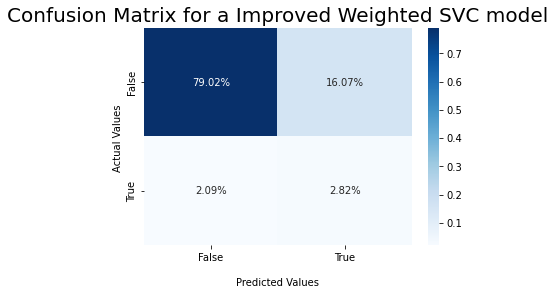

Precision:  0.14935064935064934
Recall:  0.575
F1 score:  0.23711340206185566


In [110]:
scaled_X_valid1 = scaler.transform(X_valid1)
y_pred = grid_svc.predict(scaled_X_valid1)
plot_confusion_matrix(y_valid1, y_pred, "Confusion Matrix for a Improved Weighted SVC model")

#### On a SMOTE-balanced dataset

In [111]:
gammas = [10, 1, 0.1, 0.01, 0.001, 0.0001]
Cs = [1000, 100, 10, 1, 0.1, 0.01]

In [112]:
for gamma in gammas:
  for C in Cs:
    rbf_kernel_svm_clf = Pipeline([
          ('scaler', StandardScaler()),
          ('svm_clf', SVC(kernel="rbf", gamma=gamma, C=C, random_state=random_state))  
    ])

    rbf_kernel_svm_clf.fit(smote_X_train1, smote_y_train1)

    y_pred = rbf_kernel_svm_clf.predict(X_valid1)

    conf_mat = confusion_matrix(y_valid1, y_pred)
    print("-----------------------------------SVC with parameters Gamma=", gamma, ", C=", C, "----------------------------------")
    # plot_confusion_matrix_with_percentages(conf_mat, "Confusion Matrix for a SVC model trained on an artificially Balanced Dataset")
    print_metrics(y_valid1, y_pred)

-----------------------------------SVC with parameters Gamma= 10 , C= 1000 ----------------------------------
Precision:  0.02857142857142857
Recall:  0.025
F1 score:  0.026666666666666665
-----------------------------------SVC with parameters Gamma= 10 , C= 100 ----------------------------------
Precision:  0.02857142857142857
Recall:  0.025
F1 score:  0.026666666666666665
-----------------------------------SVC with parameters Gamma= 10 , C= 10 ----------------------------------
Precision:  0.030303030303030304
Recall:  0.025
F1 score:  0.027397260273972605
-----------------------------------SVC with parameters Gamma= 10 , C= 1 ----------------------------------
Precision:  0.0
Recall:  0.0
F1 score:  0.0
-----------------------------------SVC with parameters Gamma= 10 , C= 0.1 ----------------------------------
Precision:  0.0
Recall:  0.0
F1 score:  0.0
-----------------------------------SVC with parameters Gamma= 10 , C= 0.01 ----------------------------------
Precision:  0.0
Recal

The best results could be obtained with a lower gamma (0.01) and the default C (1) hyperparameters, but we still couldn't get better results than the previous ones with class weights. The SMOTE-based oversampling does not seem a promising approach.

#### Conclusions about SVC-s

So far , it seems like SVC-s could not significantly outperform the Logistic Regressors.

**The best f1-score was 0.269** with the hyperparameters:


*   class weights: {0: 11, 1: 89}
*   C: 1
*   gamma: 0.001

These results are not strong enough to be used in a predictive model on their own, but we may consider combining these models later through Ensemble Learning techniques.

### Experiments with Random Forests Models


#### Experiments with Random Forest Classifier


[0.94969325 0.94969325 0.95092025 0.95092025 0.94963145]
Mean Accuracy:  0.9501716886992961


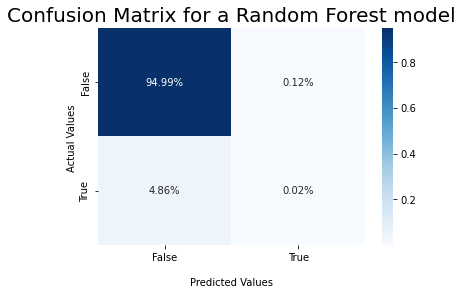

Precision:  0.16666666666666666
Recall:  0.005025125628140704
F1 score:  0.009756097560975611


In [113]:
simple_random_forest = RandomForestClassifier(random_state=random_state, criterion='entropy')
scores = cross_val_score(simple_random_forest, X_train, y_train, cv = 5)
print(scores)
mean_score = scores.mean()
print("Mean Accuracy: ", mean_score)

call_cross_val_predict(simple_random_forest, X_train, y_train, "Confusion Matrix for a Random Forest model")

Although the data is not balanced and we have not applied any weights it seems that the random forest is able to give some precision but it is anyway very low, so we still have to do something about it.

#### Weighted Random Forest


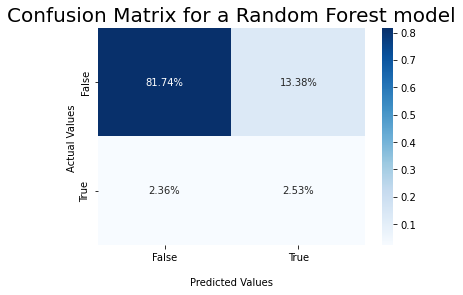

Precision:  0.15895061728395063
Recall:  0.5175879396984925
F1 score:  0.24321133412042503


In [114]:
rnd_for = RandomForestClassifier(random_state=random_state, class_weight={0:7, 1:93}, criterion='entropy',
                                 n_estimators = 100, max_leaf_nodes = 30)
call_cross_val_predict(rnd_for, X_train, y_train, "Confusion Matrix for a Random Forest model")

We have some improvement, at this point we should make a grid serach to find *   the appropiate weights
*   appropiate values for n_estimators i.e. the number of trees we will have *   the max_leaf_nodes

Note that the max_leaf_nodes hyperparameter acts as a rgeularization parameter: the more leaf nodes the trees have, the more particularities of the training data the model can learn. By restricting the number of lead nodes we force the model to learn only the properties that seem significant enough to expect that they can be generalized.

#### Grid Search

In [115]:
weight_pairs_spec = get_weight_pairs_spec(1, 20, 3)
weighted_rf = RandomForestClassifier(random_state=random_state, criterion='entropy')
param_grid = {
    'n_estimators': [50, 100, 200, 300, 400],
    'max_leaf_nodes': [5, 10, 20, 30, 40, 50],
    'class_weight': weight_pairs_spec
}
grid_search_weighted_rf = GridSearchCV(estimator = weighted_rf, cv = 3, param_grid = param_grid, 
                          scoring = ['f1', 'recall', 'precision'], refit='f1', return_train_score=True)
grid_search_weighted_rf.fit(X_train1, y_train1)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined a

GridSearchCV(cv=3,
             estimator=RandomForestClassifier(criterion='entropy',
                                              random_state=42),
             param_grid={'class_weight': [{0: 1, 1: 99}, {0: 4, 1: 96},
                                          {0: 7, 1: 93}, {0: 10, 1: 90},
                                          {0: 13, 1: 87}, {0: 16, 1: 84},
                                          {0: 19, 1: 81}],
                         'max_leaf_nodes': [5, 10, 20, 30, 40, 50],
                         'n_estimators': [50, 100, 200, 300, 400]},
             refit='f1', return_train_score=True,
             scoring=['f1', 'recall', 'precision'])

In [116]:
print(f'Best f1 score: {grid_search_weighted_rf .best_score_} with param: {grid_search_weighted_rf .best_params_}')

Best f1 score: 0.25895590687390446 with param: {'class_weight': {0: 4, 1: 96}, 'max_leaf_nodes': 30, 'n_estimators': 200}


It seems that the best f1 score we have achived is for a class weight of 96 for positive stroke, max leaf nodes = 30 and n_estimators = 200

In [117]:
get_cross_val_detailed_results_df(grid_search_weighted_rf)

,mean_test_f1,mean_train_f1,mean_test_recall,mean_train_recall,mean_test_precision,mean_train_precision,params,f1_train_test_difference
0,0.163,0.166,0.975,0.994,0.089,0.090,"{'class_weight': {0: 1, 1: 99}, 'max_leaf_node...",0.003
1,0.160,0.164,0.969,0.994,0.087,0.089,"{'class_weight': {0: 1, 1: 99}, 'max_leaf_node...",0.004
2,0.158,0.162,0.969,0.994,0.086,0.088,"{'class_weight': {0: 1, 1: 99}, 'max_leaf_node...",0.004
3,0.158,0.163,0.969,0.994,0.086,0.089,"{'class_weight': {0: 1, 1: 99}, 'max_leaf_node...",0.005
4,0.159,0.163,0.969,0.994,0.086,0.089,"{'class_weight': {0: 1, 1: 99}, 'max_leaf_node...",0.005
...,...,...,...,...,...,...,...,...
205,0.012,0.623,0.006,0.462,0.083,0.959,"{'class_weight': {0: 19, 1: 81}, 'max_leaf_nod...",0.611
206,0.000,0.638,0.000,0.475,0.000,0.974,"{'class_weight': {0: 19, 1: 81}, 'max_leaf_nod...",0.638
207,0.000,0.623,0.000,0.453,0.000,1.000,"{'class_weight': {0: 19, 1: 81}, 'max_leaf_nod...",0.623
208,0.000,0.617,0.000,0.447,0.000,1.000,"{'class_weight': {0: 19, 1: 81}, 'max_leaf_nod...",0.617


#### Evaluation on the validation set

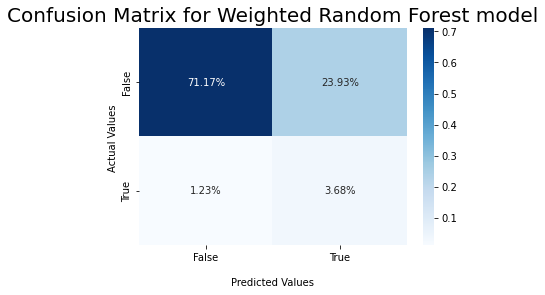

Precision:  0.13333333333333333
Recall:  0.75
F1 score:  0.22641509433962267


In [118]:
y_pred = grid_search_weighted_rf.predict(X_valid1)
plot_confusion_matrix(y_valid1, y_pred, "Confusion Matrix for Weighted Random Forest model")

This is the maximum we could achive with the weighted random forest, it seems that it didn't perform so good, not even better than the Logistic Regression.

#### SMOTE for Random Forest

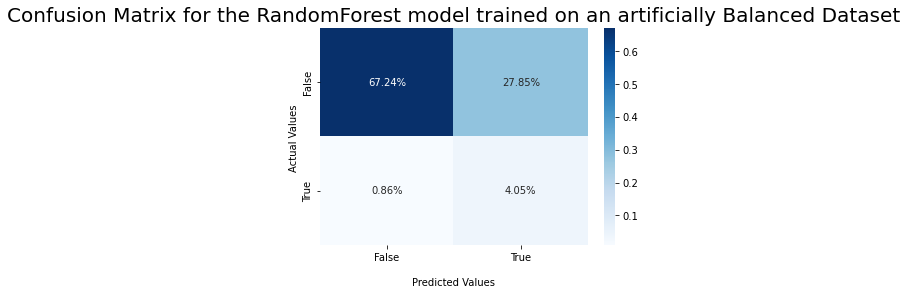

Precision:  0.12692307692307692
Recall:  0.825
F1 score:  0.22


In [119]:
smote_rf = RandomForestClassifier(random_state=random_state, criterion='entropy',
                                 n_estimators = 200, max_leaf_nodes = 30)
smote_rf.fit(smote_X_train1, smote_y_train1)
y_pred = smote_rf.predict(X_valid1)
plot_confusion_matrix(y_valid1, y_pred, "Confusion Matrix for the RandomForest model trained on an artificially Balanced Dataset")

It seems that the better result that we can achive for Random Forest is still the one obtained with the weighted class.

#### Conclusions about Random Forests

Random forests could not outpeform the LogisticRegressions and SVCs, but produces significant results.

**The best f1-score was 0.258** with the hyperparameters:


*   class weights: {0: 4, 1: 96}
*   n_estimators: 200
*   max_leaf_nodes: 30

### Combining Methods: Experiments with a Voting Classifier


Considering that neither of the models we have so far have lead to satisfying results, maybe if we combine them by using a Voting Classifer may lead to better results. For this voting classifier we will use the parameters that we found to perform best so far for each model i.e. logistic regression, SVM and random forests.

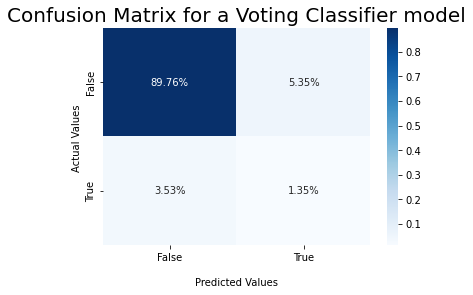

Precision:  0.20146520146520147
Recall:  0.27638190954773867
F1 score:  0.2330508474576271


In [120]:
from sklearn.ensemble import VotingClassifier

log_clf = LogisticRegression(random_state=random_state, class_weight={0:10, 1:90}, max_iter=1000, tol=1e-6)
rnd_clf = RandomForestClassifier(random_state=random_state, class_weight={0:4, 1:96}, criterion='entropy',
                                 n_estimators = 200, max_leaf_nodes = 30)
svm_clf = Pipeline([
      ('scaler', StandardScaler()),
      ('svm_clf', SVC(kernel="rbf", gamma=0.001, C=1, class_weight={0:11, 1:89},probability=True, random_state=random_state))  
])

voting_clf = VotingClassifier(
 estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
 voting='soft')

call_cross_val_predict(voting_clf, X_train, y_train,"Confusion Matrix for a Voting Classifier model")


#### Evaluation On Valid Set

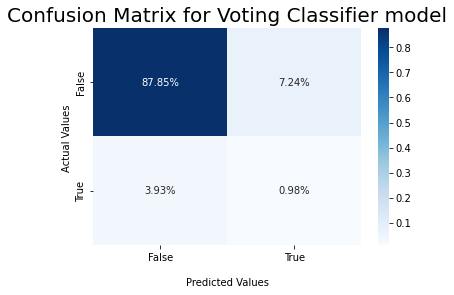

Precision:  0.11940298507462686
Recall:  0.2
F1 score:  0.14953271028037382


In [121]:
voting_clf.fit(X_train1, y_train1)
y_pred = voting_clf.predict(X_valid1)
plot_confusion_matrix(y_valid1, y_pred, "Confusion Matrix for Voting Classifier model")

It seems that this voting classifier is prone to overfitting. We could try to make a grid search to find some better parameters for every model, in the case we use them in a voting classifier.

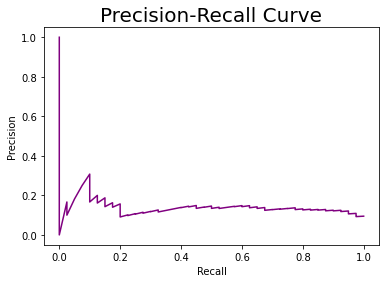

In [122]:
y_score_pred = voting_clf.predict_proba(X_valid1)[:, 1]
plot_precision_recall_curve(y_valid1, y_score_pred)

The PR curve shows that we might get a slightly bigger precision with this classifier (to an expense of a very small recall). But even so the precison is still very small, so it might not be worth.

#### Randomized Search for Voting Classifier

In [125]:
from sklearn.model_selection import RandomizedSearchCV

weight_pairs_spec = get_weight_pairs_spec(1, 11, 3)

grid_voting_clf = VotingClassifier(
 estimators=[('lr', LogisticRegression(max_iter=1000, random_state=random_state)), ('rf', RandomForestClassifier(random_state=random_state)), ('svm', SVC(probability=True, random_state=random_state))],
 voting='soft')
param_grid = {
    'rf__n_estimators': [50, 100, 200, 300, 400],
    'rf__max_leaf_nodes': [5, 10, 20, 30, 40, 50],
    'rf__class_weight': weight_pairs_spec,
    'lr__class_weight': weight_pairs_spec,
    'svm__class_weight': weight_pairs_spec,
    'svm__C': [10, 5, 1, 0.1],
    'svm__gamma': [0.005, 0.001],
    'svm__kernel': ['rbf']
}

rand_search_voting_clf = RandomizedSearchCV(estimator=grid_voting_clf, param_distributions=param_grid, n_iter = 20, cv=5, scoring = ['f1', 'recall', 'precision'], refit='f1', return_train_score=True, random_state=random_state)

rand_search_voting_clf.fit(X_train1, y_train1)

RandomizedSearchCV(cv=5,
                   estimator=VotingClassifier(estimators=[('lr',
                                                           LogisticRegression(max_iter=1000,
                                                                              random_state=42)),
                                                          ('rf',
                                                           RandomForestClassifier(random_state=42)),
                                                          ('svm',
                                                           SVC(probability=True,
                                                               random_state=42))],
                                              voting='soft'),
                   n_iter=20,
                   param_distributions={'lr__class_weight': [{0: 1, 1: 99},
                                                             {0: 4, 1: 96},
                                                             {0: 7, 1: 93},
    

In [126]:
print(f'Best f1 score: {rand_search_voting_clf .best_score_} with param: {rand_search_voting_clf .best_params_}')

Best f1 score: 0.2801519188667377 with param: {'svm__kernel': 'rbf', 'svm__gamma': 0.005, 'svm__class_weight': {0: 10, 1: 90}, 'svm__C': 5, 'rf__n_estimators': 300, 'rf__max_leaf_nodes': 30, 'rf__class_weight': {0: 4, 1: 96}, 'lr__class_weight': {0: 4, 1: 96}}


In [127]:
get_cross_val_detailed_results_df(rand_search_voting_clf)

,mean_test_f1,mean_train_f1,mean_test_recall,mean_train_recall,mean_test_precision,mean_train_precision,params,f1_train_test_difference
0,0.260,0.424,0.309,0.523,0.231,0.357,"{'svm__kernel': 'rbf', 'svm__gamma': 0.005, 's...",0.163
1,0.254,0.337,0.679,0.901,0.156,0.208,"{'svm__kernel': 'rbf', 'svm__gamma': 0.005, 's...",0.083
2,0.280,0.356,0.503,0.649,0.194,0.245,"{'svm__kernel': 'rbf', 'svm__gamma': 0.005, 's...",0.075
3,0.234,0.420,0.239,0.431,0.238,0.410,"{'svm__kernel': 'rbf', 'svm__gamma': 0.005, 's...",0.186
4,0.274,0.324,0.547,0.646,0.183,0.216,"{'svm__kernel': 'rbf', 'svm__gamma': 0.001, 's...",0.049
5,0.260,0.327,0.453,0.577,0.182,0.228,"{'svm__kernel': 'rbf', 'svm__gamma': 0.005, 's...",0.067
6,0.212,0.427,0.189,0.403,0.250,0.455,"{'svm__kernel': 'rbf', 'svm__gamma': 0.005, 's...",0.214
7,0.263,0.421,0.390,0.651,0.199,0.311,"{'svm__kernel': 'rbf', 'svm__gamma': 0.005, 's...",0.158
8,0.255,0.393,0.365,0.575,0.196,0.299,"{'svm__kernel': 'rbf', 'svm__gamma': 0.001, 's...",0.139
9,0.215,0.237,0.849,0.928,0.123,0.136,"{'svm__kernel': 'rbf', 'svm__gamma': 0.005, 's...",0.022


##### Evaluation on Valid Set

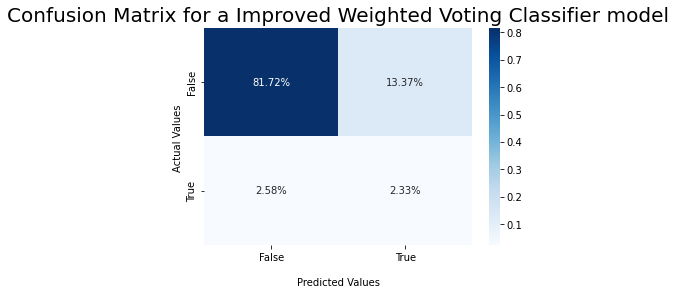

Precision:  0.1484375
Recall:  0.475
F1 score:  0.22619047619047622


In [128]:
y_pred = rand_search_voting_clf.predict(X_valid1)
plot_confusion_matrix(y_valid1, y_pred, "Confusion Matrix for a Improved Weighted Voting Classifier model")

It seems that we managed to improve a bit the Voting Classifier by making a randomized search, but it still does not perfom better than the previous models alone.

#### SMOTE for Voting Classifier

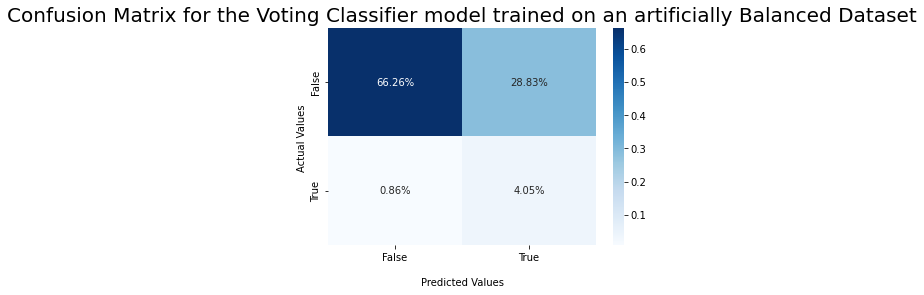

Precision:  0.12313432835820895
Recall:  0.825
F1 score:  0.21428571428571427


In [130]:
log_clf_smote = LogisticRegression(random_state=random_state, max_iter=1000, tol=1e-6)
rnd_clf_smote = RandomForestClassifier(random_state=random_state, criterion='entropy',
                                 n_estimators = 200, max_leaf_nodes = 30)
svm_clf_smote = Pipeline([
      ('scaler', StandardScaler()),
      ('svm_clf', SVC(kernel="rbf", gamma=0.001, C=1, probability=True, random_state=random_state))  
])

voting_clf_smote = VotingClassifier(
 estimators=[('lr', log_clf_smote), ('rf', rnd_clf_smote), ('svc', svm_clf_smote)],
 voting='soft')
voting_clf_smote.fit(smote_X_train1, smote_y_train1)
y_pred = voting_clf_smote.predict(X_valid1)
plot_confusion_matrix(y_valid1, y_pred, "Confusion Matrix for the Voting Classifier model trained on an artificially Balanced Dataset")

With smote we obtained some better recall but also some less precision. It seems that still the weighted randomized search voting classifier is a bit better.

#### Conclusions about Voting Classifiers

As expected, combining 3 different models produces better results, but the difference is not as large as we hoped.

**The best f1-score was 0.28** with the hyperparameters

*  'svm__gamma': 0.005
*  'svm__class_weight': {0: 10, 1: 90}
*  'svm__C': 5
*  'rf__n_estimators': 300
*  'rf__max_leaf_nodes': 30
*  'rf__class_weight': {0: 4, 1: 96}
*  'lr__class_weight': {0: 4, 1: 96}

**The reason for not reaching a greater improvement may be that while the 3 previous models were trained based on completely different techniques, they still may have reached very similar conclusions and may have made very similar mistakes.** Thus, combining them is not significantly better than using any one of them on its own.

It is not the case here, but if we had limited computational resources, then using just a simple SVC instead of the voting classifier may be a better choise than training all three models and making 3 predictions for each instance: the cost vs quality improvement ratio is simpl too low.



### Experiments with Neural Networks

#### Helprer functions

In [131]:
def plot_loss_accuracy_history(history):
  plt.figure(figsize=(16, 8))

  plt.subplot(1, 2, 1)
  plt.plot(pd.DataFrame(history.history['accuracy']))
  plt.plot(pd.DataFrame(history.history['val_accuracy']))
  plt.grid(True)
  plt.title("Accuracy")
  plt.gca().legend(('training accuracy', 'validation accuracy'))

  plt.subplot(1, 2, 2)
  plt.plot(pd.DataFrame(history.history['loss']))
  plt.plot(pd.DataFrame(history.history['val_loss']))
  plt.grid(True)
  plt.title("Loss")
  plt.gca().legend(('training loss', 'validation loss'))
  plt.show()

#### Initial Network


Build an initial, experimental neural network with 2 hidden layers, 30 neurons each.

In [132]:
input_ = keras.layers.Input(shape=X_train.shape[1:])
hidden1 = keras.layers.Dense(30, activation="relu")(input_)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
output = keras.layers.Dense(1, activation='sigmoid')(hidden2)
model = keras.models.Model(inputs=[input_], outputs=[output])

model.summary()

reset_seeds()
model.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1e-2), metrics=['accuracy'])
history = model.fit(X_train1, y_train1, epochs=100,
                    validation_data=(X_valid1, y_valid1))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 17)]              0         
                                                                 
 dense (Dense)               (None, 30)                540       
                                                                 
 dense_1 (Dense)             (None, 30)                930       
                                                                 
 dense_2 (Dense)             (None, 1)                 31        
                                                                 
Total params: 1,501
Trainable params: 1,501
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
102/102 [==============================] - 1s 4ms/step - loss: 0.3683 - accuracy: 0.9512 - val_loss: 0.2637 - val_accuracy: 0.9509
Epoch 2/100
102/102 [===========================

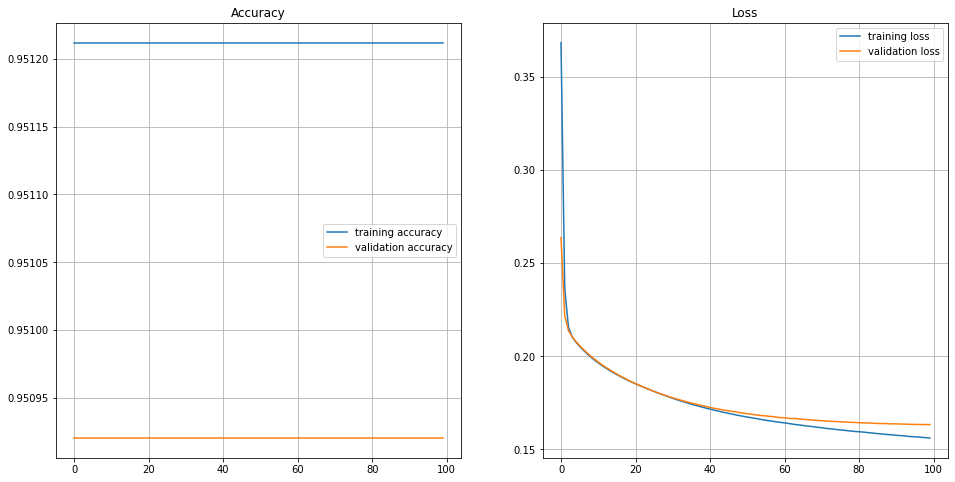

In [133]:
plot_loss_accuracy_history(history)

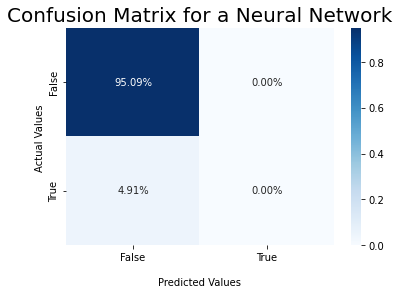

Precision:  0.0
Recall:  0.0
F1 score:  0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [134]:
y_pred = model.predict(X_valid1) >= 0.5
conf_mat = confusion_matrix(y_valid1, y_pred)
plot_confusion_matrix_with_percentages(conf_mat, "Confusion Matrix for a Neural Network")
print_metrics(y_valid1, y_pred)

As we have seen with several previous model, if no class weights are applied, the ANN simply predicts everyone to have no stroke.

#### Applying class weights

In [135]:
input2_ = keras.layers.Input(shape=X_train.shape[1:])
hidden21 = keras.layers.Dense(30, activation="relu")(input2_)
hidden22 = keras.layers.Dense(30, activation="relu")(hidden21)
output2 = keras.layers.Dense(1, activation='sigmoid')(hidden22)
model2 = keras.models.Model(inputs=[input2_], outputs=[output2])

model2.summary()

reset_seeds()
model2.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1e-2), metrics=['accuracy'])
history2 = model2.fit(X_train1, y_train1, epochs=500, class_weight={0:5, 1:95},
                    validation_data=(X_valid1, y_valid1))

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 17)]              0         
                                                                 
 dense_3 (Dense)             (None, 30)                540       
                                                                 
 dense_4 (Dense)             (None, 30)                930       
                                                                 
 dense_5 (Dense)             (None, 1)                 31        
                                                                 
Total params: 1,501
Trainable params: 1,501
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
102/102 [==============================] - 1s 3ms/step - loss: 6.4431 - accuracy: 0.6029 - val_loss: 0.6110 - val_accuracy: 0.7239
Epoch 2/500
102/102 [=========================

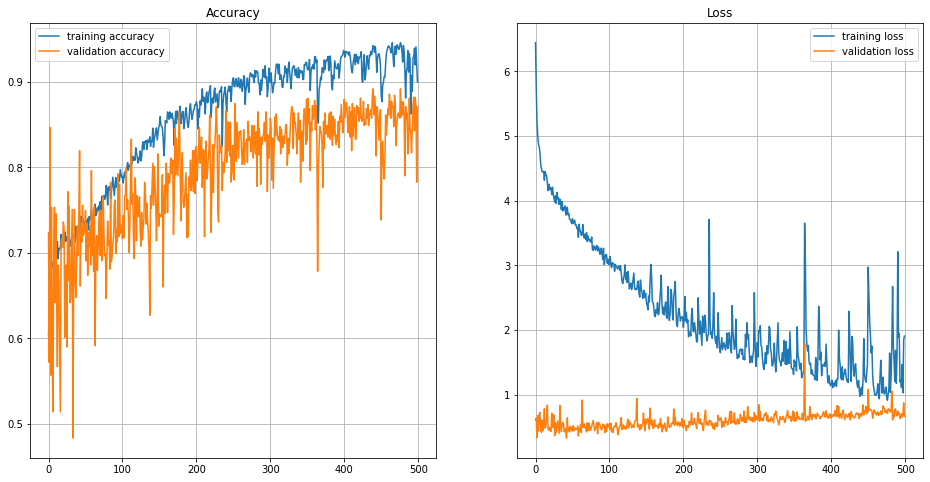

In [136]:
plot_loss_accuracy_history(history2)

We can see a constant improvement, however, the model didn't converge yet.

We'll evaluate the current results, and then we'll try using an optimizer to make the model converge faster.

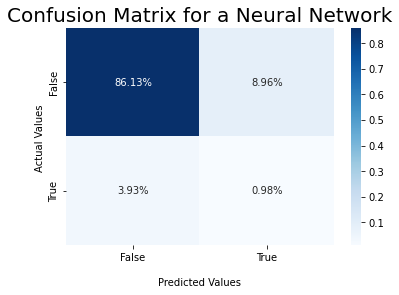

Precision:  0.09876543209876543
Recall:  0.2
F1 score:  0.1322314049586777


In [137]:
y_pred = model2.predict(X_valid1) >= 0.5
conf_mat = confusion_matrix(y_valid1, y_pred)
plot_confusion_matrix_with_percentages(conf_mat, "Confusion Matrix for a Neural Network")
print_metrics(y_valid1, y_pred)

#### Using a nadam optimizer

In [138]:
input3_ = keras.layers.Input(shape=X_train.shape[1:])
hidden31 = keras.layers.Dense(30, activation="relu")(input3_)
hidden32 = keras.layers.Dense(30, activation="relu")(hidden31)
output3 = keras.layers.Dense(1, activation='sigmoid')(hidden32)
model3 = keras.models.Model(inputs=[input3_], outputs=[output3])

reset_seeds()
model3.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Nadam(learning_rate=1e-2), metrics=['accuracy'])
history3 = model3.fit(X_train1, y_train1, epochs=500,
                      class_weight={0:5, 1:95},
                    validation_data=(X_valid1, y_valid1))

Epoch 1/500
102/102 [==============================] - 1s 3ms/step - loss: 5.7603 - accuracy: 0.6634 - val_loss: 0.4647 - val_accuracy: 0.7362
Epoch 2/500
102/102 [==============================] - 0s 2ms/step - loss: 5.0090 - accuracy: 0.6668 - val_loss: 0.5759 - val_accuracy: 0.6515
Epoch 3/500
102/102 [==============================] - 0s 2ms/step - loss: 4.9611 - accuracy: 0.6790 - val_loss: 0.4233 - val_accuracy: 0.7472
Epoch 4/500
102/102 [==============================] - 0s 2ms/step - loss: 4.7177 - accuracy: 0.7094 - val_loss: 0.6974 - val_accuracy: 0.5742
Epoch 5/500
102/102 [==============================] - 0s 2ms/step - loss: 4.6995 - accuracy: 0.6879 - val_loss: 0.4672 - val_accuracy: 0.7325
Epoch 6/500
102/102 [==============================] - 0s 2ms/step - loss: 4.6318 - accuracy: 0.6870 - val_loss: 0.5682 - val_accuracy: 0.6577
Epoch 7/500
102/102 [==============================] - 0s 2ms/step - loss: 4.4810 - accuracy: 0.7073 - val_loss: 0.7288 - val_accuracy: 0.5215

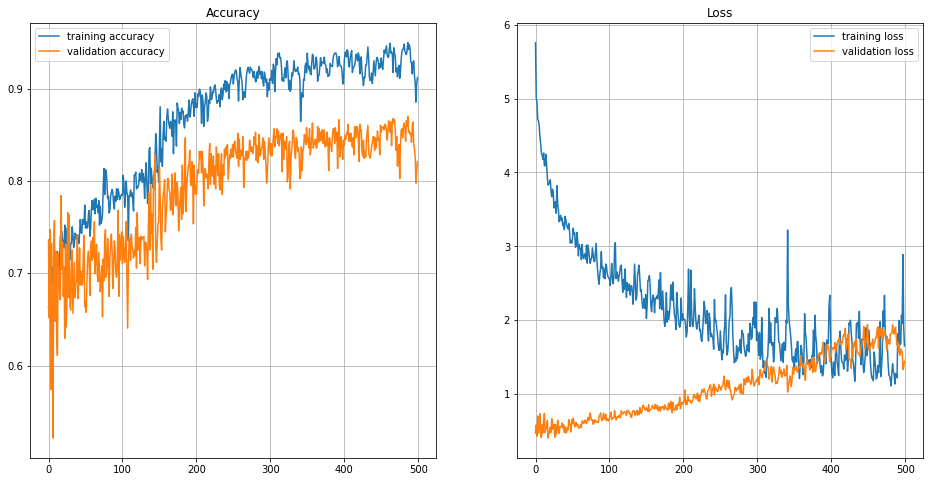

In [139]:
plot_loss_accuracy_history(history3)

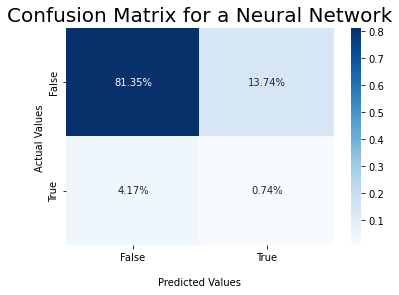

Precision:  0.05084745762711865
Recall:  0.15
F1 score:  0.0759493670886076


In [140]:
y_pred = model3.predict(X_valid1) >= 0.5
conf_mat = confusion_matrix(y_valid1, y_pred)
plot_confusion_matrix_with_percentages(conf_mat, "Confusion Matrix for a Neural Network")
print_metrics(y_valid1, y_pred)

While the nadam optimizers allows the model to seemingly **learn quicker**, in fact the model seems to have learn some particularities of the training dataset and is **severely overfitted**: the loss for the validation dataset has a continuously increasing trend, while the accuracy seems to have converged earlier. Let's consider the following options to avoid overfitting:
*   **stop earlier in the training process**
*   **apply a regularization penalty**

#### Early Stopping

In [141]:
input4_ = keras.layers.Input(shape=X_train.shape[1:])
hidden41 = keras.layers.Dense(30, activation="relu")(input4_)
hidden42 = keras.layers.Dense(30, activation="relu")(hidden41)
output4 = keras.layers.Dense(1, activation='sigmoid')(hidden42)
model4 = keras.models.Model(inputs=[input4_], outputs=[output4])

reset_seeds()
model4.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Nadam(learning_rate=1e-2), metrics=['accuracy'])
history4 = model4.fit(X_train1, y_train1, epochs=80,
                      class_weight={0:5, 1:95},
                    validation_data=(X_valid1, y_valid1))

Epoch 1/80
102/102 [==============================] - 1s 4ms/step - loss: 5.7603 - accuracy: 0.6634 - val_loss: 0.4647 - val_accuracy: 0.7362
Epoch 2/80
102/102 [==============================] - 0s 2ms/step - loss: 5.0090 - accuracy: 0.6668 - val_loss: 0.5759 - val_accuracy: 0.6515
Epoch 3/80
102/102 [==============================] - 0s 3ms/step - loss: 4.9611 - accuracy: 0.6790 - val_loss: 0.4233 - val_accuracy: 0.7472
Epoch 4/80
102/102 [==============================] - 0s 3ms/step - loss: 4.7177 - accuracy: 0.7094 - val_loss: 0.6974 - val_accuracy: 0.5742
Epoch 5/80
102/102 [==============================] - 0s 2ms/step - loss: 4.6995 - accuracy: 0.6879 - val_loss: 0.4672 - val_accuracy: 0.7325
Epoch 6/80
102/102 [==============================] - 0s 2ms/step - loss: 4.6318 - accuracy: 0.6870 - val_loss: 0.5682 - val_accuracy: 0.6577
Epoch 7/80
102/102 [==============================] - 0s 2ms/step - loss: 4.4810 - accuracy: 0.7073 - val_loss: 0.7288 - val_accuracy: 0.5215
Epoch 

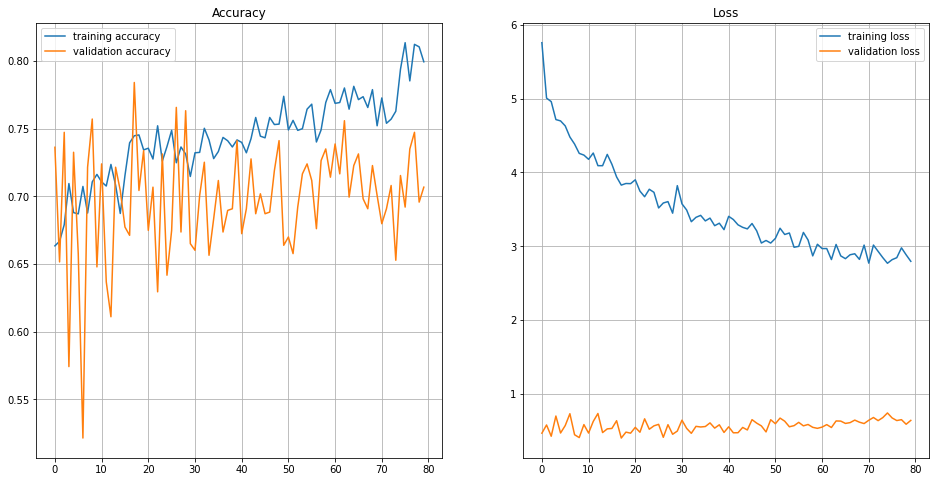

In [142]:
plot_loss_accuracy_history(history4)

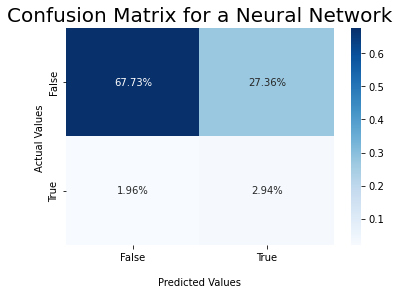

Precision:  0.09716599190283401
Recall:  0.6
F1 score:  0.16724738675958187


In [143]:
y_pred = model4.predict(X_valid1) >= 0.5
conf_mat = confusion_matrix(y_valid1, y_pred)
plot_confusion_matrix_with_percentages(conf_mat, "Confusion Matrix for a Neural Network")
print_metrics(y_valid1, y_pred)

Early stopping has indeed increased the f1-score by a factor of >2, and with early stopping, the Nadam optimizer leads to **a little better result as the model with the default optimizer, in a significantly shorter time**.

#### Regularization: avoid overfitting

Despite early stopping, we can see that the validation loss is still increasing starting from the ~50th epoch. To reduce the chance of overfitting even more, let's apply a regularization penalty.

Moreover, for the model above we can see that the recall is quite good but the precision is below 10%. To improve the precision (which in this case has a higher weight in the low f1-score), we should increase a little bit the weight of the majority class (stroke=0).

In [144]:
input7_ = keras.layers.Input(shape=X_train.shape[1:])
hidden71 = keras.layers.Dense(30, activation="relu",
                              kernel_regularizer=regularizers.L2(0.5))(input7_)
hidden72 = keras.layers.Dense(30, activation="relu", kernel_regularizer=regularizers.L2(0.1))(hidden71)
output7 = keras.layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.L2(0.1))(hidden72)
model7 = keras.models.Model(inputs=[input7_], outputs=[output7])

reset_seeds()
model7.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Nadam(learning_rate=1e-2), metrics=['accuracy'])
history7 = model7.fit(X_train1, y_train1, epochs=80,
                      class_weight={0:10, 1:90},
                    validation_data=(X_valid1, y_valid1))

Epoch 1/80
102/102 [==============================] - 1s 4ms/step - loss: 10.7894 - accuracy: 0.9417 - val_loss: 1.1131 - val_accuracy: 0.9509
Epoch 2/80
102/102 [==============================] - 0s 2ms/step - loss: 8.3381 - accuracy: 0.8905 - val_loss: 1.4004 - val_accuracy: 0.8245
Epoch 3/80
102/102 [==============================] - 0s 2ms/step - loss: 8.3191 - accuracy: 0.8272 - val_loss: 1.1298 - val_accuracy: 0.9509
Epoch 4/80
102/102 [==============================] - 0s 2ms/step - loss: 8.2366 - accuracy: 0.8714 - val_loss: 1.3763 - val_accuracy: 0.7472
Epoch 5/80
102/102 [==============================] - 0s 2ms/step - loss: 8.2138 - accuracy: 0.8653 - val_loss: 1.2257 - val_accuracy: 0.9215
Epoch 6/80
102/102 [==============================] - 0s 2ms/step - loss: 8.2032 - accuracy: 0.8518 - val_loss: 1.3974 - val_accuracy: 0.7926
Epoch 7/80
102/102 [==============================] - 0s 2ms/step - loss: 8.1652 - accuracy: 0.8423 - val_loss: 1.3076 - val_accuracy: 0.8405
Epoch

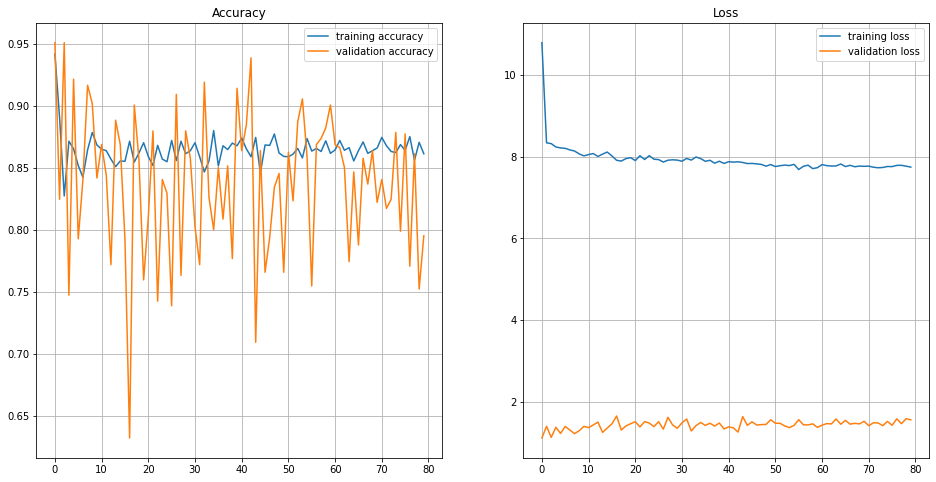

In [145]:
plot_loss_accuracy_history(history7)

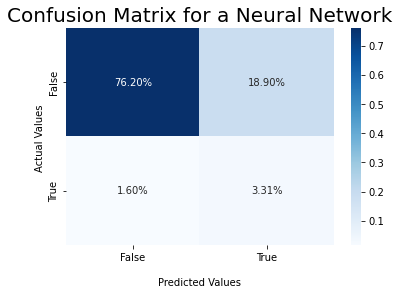

Precision:  0.14917127071823205
Recall:  0.675
F1 score:  0.24434389140271498


In [146]:
y_pred = model7.predict(X_valid1) >= 0.5
conf_mat = confusion_matrix(y_valid1, y_pred)
plot_confusion_matrix_with_percentages(conf_mat, "Confusion Matrix for a Neural Network")
print_metrics(y_valid1, y_pred)

This is **our best result with neural networks so far**, and it is finally a result close to the ones produced by the previous ML algorithms.

#### Neural Network with f1-loss

We can observe an unexpected trend in the loss and accuracy functions above:

*   the validation loss is lower than the training loss, and is increasing while the training loss is decreasing
*   the accuracy is increasing both for the training and the validation set

We may notice that the binary crossentropy, used for the loss, is not a good indicator of the final f1-score. Thus, we may try to use a loss functions that is closer to the f1 score (actually, its inverse, since the loss function should be minimized and the score should be maximized).

Since the f1-score function is not differentiable, the following modified version of it will be used.

In [147]:
import keras.backend as K

def f1_loss(y_true, y_pred):
    '''
    source: https://www.kaggle.com/code/rejpalcz/best-loss-function-for-f1-score-metric/notebook
    '''
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - K.mean(f1)


In [148]:
input5_ = keras.layers.Input(shape=X_train.shape[1:])
hidden51 = keras.layers.Dense(30, activation="relu")(input5_)
hidden52 = keras.layers.Dense(30, activation="relu")(hidden51)
output5 = keras.layers.Dense(1, activation='sigmoid')(hidden52)
model5 = keras.models.Model(inputs=[input5_], outputs=[output5])

reset_seeds() 
model5.compile(loss=f1_loss, optimizer=keras.optimizers.Nadam(learning_rate=5e-3), metrics=['accuracy'])
history5 = model5.fit(X_train1, y_train1, epochs=200,
                      class_weight={0:5, 1:95},
                    validation_data=(X_valid1, y_valid1),
                    batch_size=500)

Epoch 1/200
7/7 [==============================] - 1s 31ms/step - loss: 8.5797 - accuracy: 0.9119 - val_loss: 0.9100 - val_accuracy: 0.7902
Epoch 2/200
7/7 [==============================] - 0s 5ms/step - loss: 8.5060 - accuracy: 0.7070 - val_loss: 0.8992 - val_accuracy: 0.6908
Epoch 3/200
7/7 [==============================] - 0s 5ms/step - loss: 8.3701 - accuracy: 0.7346 - val_loss: 0.8735 - val_accuracy: 0.8405
Epoch 4/200
7/7 [==============================] - 0s 5ms/step - loss: 8.0680 - accuracy: 0.8757 - val_loss: 0.8353 - val_accuracy: 0.8368
Epoch 5/200
7/7 [==============================] - 0s 6ms/step - loss: 7.7075 - accuracy: 0.8687 - val_loss: 0.8071 - val_accuracy: 0.8896
Epoch 6/200
7/7 [==============================] - 0s 5ms/step - loss: 7.4397 - accuracy: 0.8905 - val_loss: 0.7920 - val_accuracy: 0.8503
Epoch 7/200
7/7 [==============================] - 0s 5ms/step - loss: 7.2700 - accuracy: 0.8773 - val_loss: 0.7861 - val_accuracy: 0.8589
Epoch 8/200
7/7 [=========

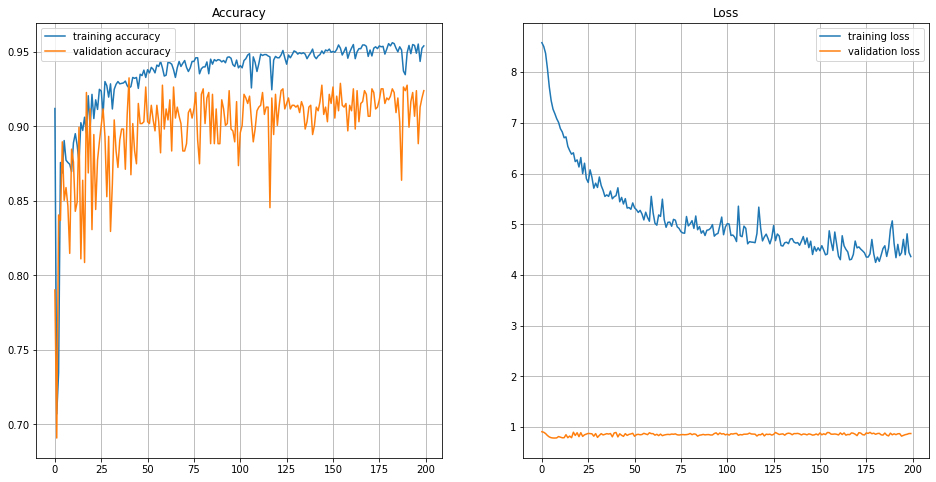

In [149]:
plot_loss_accuracy_history(history5)

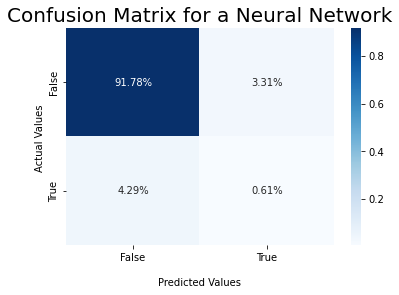

Precision:  0.15625
Recall:  0.125
F1 score:  0.1388888888888889


In [150]:
y_pred = model5.predict(X_valid1) >= 0.5
conf_mat = confusion_matrix(y_valid1, y_pred)
plot_confusion_matrix_with_percentages(conf_mat, "Confusion Matrix for a Neural Network")
print_metrics(y_valid1, y_pred)

##### With regularization and early stopping

In [151]:
input6_ = keras.layers.Input(shape=X_train.shape[1:])
hidden61 = keras.layers.Dense(30, activation="relu",
                              kernel_regularizer=regularizers.L2(0.01))(input6_)
hidden62 = keras.layers.Dense(30, activation="relu", kernel_regularizer=regularizers.L2(0.01))(hidden61)
output6 = keras.layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.L2(0.01))(hidden62)
model6 = keras.models.Model(inputs=[input6_], outputs=[output6])

reset_seeds()
model6.compile(loss=f1_loss, optimizer=keras.optimizers.Nadam(learning_rate=5e-3), metrics=['accuracy'])
history6 = model6.fit(X_train1, y_train1, epochs=20,
                      class_weight={0:10, 1:90},
                    validation_data=(X_valid1, y_valid1),
                    batch_size=500)

Epoch 1/20
7/7 [==============================] - 2s 37ms/step - loss: 13.1942 - accuracy: 0.9190 - val_loss: 1.3496 - val_accuracy: 0.8307
Epoch 2/20
7/7 [==============================] - 0s 5ms/step - loss: 13.0308 - accuracy: 0.6858 - val_loss: 1.2724 - val_accuracy: 0.5804
Epoch 3/20
7/7 [==============================] - 0s 5ms/step - loss: 12.8561 - accuracy: 0.5937 - val_loss: 1.2096 - val_accuracy: 0.6810
Epoch 4/20
7/7 [==============================] - 0s 5ms/step - loss: 12.5789 - accuracy: 0.7570 - val_loss: 1.1633 - val_accuracy: 0.7521
Epoch 5/20
7/7 [==============================] - 0s 6ms/step - loss: 12.1557 - accuracy: 0.8214 - val_loss: 1.1333 - val_accuracy: 0.8650
Epoch 6/20
7/7 [==============================] - 0s 6ms/step - loss: 11.6796 - accuracy: 0.8757 - val_loss: 1.1224 - val_accuracy: 0.8503
Epoch 7/20
7/7 [==============================] - 0s 5ms/step - loss: 11.2873 - accuracy: 0.8751 - val_loss: 1.1246 - val_accuracy: 0.8601
Epoch 8/20
7/7 [==========

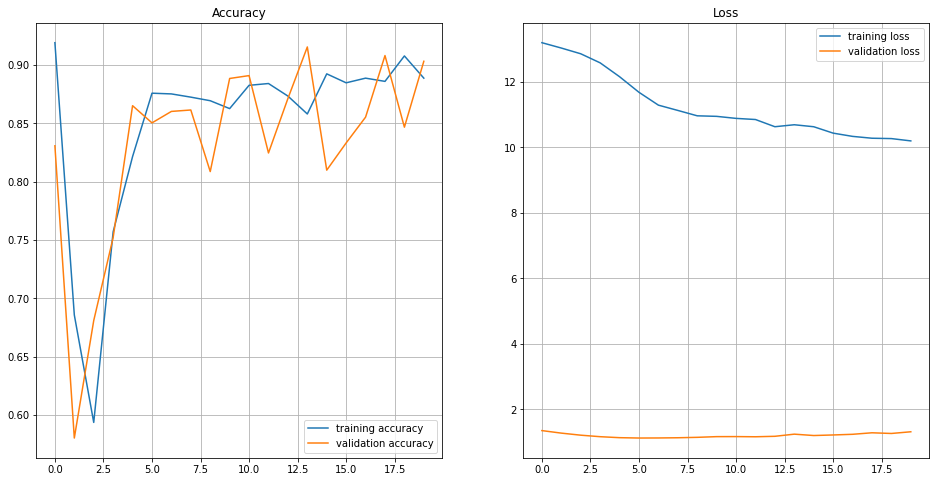

In [152]:
plot_loss_accuracy_history(history6)

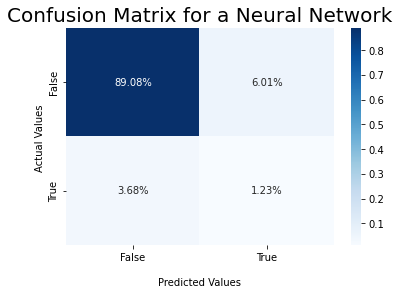

Precision:  0.1694915254237288
Recall:  0.25
F1 score:  0.20202020202020202


In [153]:
y_pred = model6.predict(X_valid1) >= 0.5
conf_mat = confusion_matrix(y_valid1, y_pred)
plot_confusion_matrix_with_percentages(conf_mat, "Confusion Matrix for a Neural Network")
print_metrics(y_valid1, y_pred)

Overall, the f1-score-based loss got in the same range as the binary crossentropy, but could not even get close to it: binary crossentropy still seems to perform better.

#### Conclusions about ANNs

Overall, the artificial neural networks reached a similar f1-score as the previous algorithms, but could not beat their record.

**The best f1-score was 0.244** for a network with

*   L2 regularization on each layer
*   binary crossentropy loss
*   class weights {0: 10, 1:90}